In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-crocodile-species-dataset/crocodile_dataset.csv


In [2]:
# =================================================================
# STEP 1: AUTOMATIC SETUP AND DATA LOADING (Production Ready)
# =================================================================

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split # Keep this for later
# Import only necessary metrics for evaluation later
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error 

# --- 1. Configuration (Constants) ---
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE) 
print(f"Random seed set to: {RANDOM_STATE}")

FILE_PATH = '/kaggle/input/global-crocodile-species-dataset/crocodile_dataset.csv'
TARGET_FEATURE = 'Conservation Status'

# --- 2. Data Loading ---
try:
    df = pd.read_csv(FILE_PATH)
    print(f"\nData Loaded Successfully: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print(f"FATAL ERROR: The file '{FILE_PATH}' was not found.")
    df = pd.DataFrame() 

# --- 3. Automatic Problem Identification Function (The core change) ---
def identify_problem_type(df: pd.DataFrame, target_col: str):
    """
    Automatically determines if the problem is Regression, Binary, or Multi-class Classification.
    """
    if df.empty or target_col not in df.columns:
        return "Unknown (Error)", "N/A"

    target_data = df[target_col]
    unique_count = target_data.nunique()
    
    # 1. Check for Regression
    # If the target is a numeric type and has many unique values, it's Regression.
    if pd.api.types.is_numeric_dtype(target_data) and unique_count > 25: # Heuristic threshold
        return "Regression", "RMSE / R-squared"
    
    # 2. Check for Classification
    else:
        if unique_count == 2:
            return "Binary Classification", "F1-Score / ROC-AUC"
        elif unique_count > 2:
            return "Multi-class Classification", "Weighted F1-Score / Accuracy"
        else:
            return "Unknown (Insufficient data)", "N/A"

# --- 4. Execution of Auto-Identification ---
if not df.empty:
    PROBLEM_TYPE, PRIMARY_METRIC = identify_problem_type(df, TARGET_FEATURE)
    print(f"\n[AUTO-IDENTIFIED PROBLEM]: {PROBLEM_TYPE}")
    print(f"[PRIMARY OPTIMIZATION METRIC]: {PRIMARY_METRIC}")
    print("-" * 30)

    # Display initial data for visual confirmation
    print(df.head())

Random seed set to: 42

Data Loaded Successfully: 1000 rows, 15 columns

[AUTO-IDENTIFIED PROBLEM]: Multi-class Classification
[PRIMARY OPTIMIZATION METRIC]: Weighted F1-Score / Accuracy
------------------------------
   Observation ID                         Common Name         Scientific Name  \
0               1                 Morelet's Crocodile    Crocodylus moreletii   
1               2                  American Crocodile       Crocodylus acutus   
2               3                   Orinoco Crocodile  Crocodylus intermedius   
3               4                 Morelet's Crocodile    Crocodylus moreletii   
4               5  Mugger Crocodile (Marsh Crocodile)    Crocodylus palustris   

         Family       Genus  Observed Length (m)  Observed Weight (kg)  \
0  Crocodylidae  Crocodylus                 1.90                  62.0   
1  Crocodylidae  Crocodylus                 4.09                 334.5   
2  Crocodylidae  Crocodylus                 1.08                 118.2   

In [3]:
# =================================================================
# STEP 2: EXECUTION OF UTILITIES AND DETAILED FEATURE ANALYSIS
# =================================================================

import pandas as pd
import numpy as np

# --- 1. Define Utility Functions (Paste yours here) ---

def load_data(path: str) -> pd.DataFrame:
    """Load data from CSV or other formats."""
    # Added robust error handling
    try:
        df = pd.read_csv(path)
        print(f"Data loaded successfully with shape: {df.shape}")
        return df
    except Exception as e:
        print(f"FATAL ERROR loading data: {e}")
        return pd.DataFrame()

def detect_problem_type(df: pd.DataFrame, target_col: str = None) -> str:
    """Detect ML problem type based on target column and data characteristics."""
    # (Paste the rest of your detect_problem_type function here)
    if target_col is None or target_col not in df.columns:
        return "unsupervised (clustering or other)"
    
    target = df[target_col]
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns
    
    if pd.api.types.is_datetime64_any_dtype(df.index) or len(datetime_cols) > 0:
        if pd.api.types.is_numeric_dtype(target):
            return "time series regression"
        else:
            return "time series classification"
    
    if pd.api.types.is_numeric_dtype(target):
        unique_vals = target.nunique()
        if unique_vals > 20: # Heuristic threshold
            return "regression"
        else:
            return "classification"
    
    if pd.api.types.is_categorical_dtype(target) or target.dtype == object:
        unique_count = target.nunique()
        if unique_count > 2:
            return "multi-class classification" # Refined from 'classification'
        elif unique_count == 2:
            return "binary classification"
        else:
            return "classification"

    return "unknown"

# --- 2. Execution (Using your constants from Step 1) ---

# Re-define constants from Step 1 to ensure context is retained
FILE_PATH = '/kaggle/input/global-crocodile-species-dataset/crocodile_dataset.csv'
TARGET_FEATURE = 'Conservation Status'

df = load_data(FILE_PATH)
if df.empty:
    raise SystemExit("Exiting due to data loading failure.")

PROBLEM_TYPE = detect_problem_type(df, TARGET_FEATURE)
print(f"Detected problem type: {PROBLEM_TYPE}")
print("-" * 30)


# --- 3. Detailed Feature Analysis (The necessary EDA) ---

# Missing Value Check
print("\n--- Missing Value Check (Key Numerical Columns) ---")
missing_cols = ['Observed Length (m)', 'Observed Weight (kg)']
missing_data = df[missing_cols].isnull().sum()
print(missing_data if missing_data.any() else "No missing values in key numerical columns.")

# Cardinality Check to decide on dropping columns
print("\n--- Categorical Feature Cardinality Analysis ---")
string_cols = df.select_dtypes(include='object').columns.tolist()
if TARGET_FEATURE in string_cols: string_cols.remove(TARGET_FEATURE) 

HIGH_CARDINALITY_THRESHOLD = 50 
COLUMNS_TO_DROP = []

for col in string_cols:
    unique_count = df[col].nunique()
    if unique_count > HIGH_CARDINALITY_THRESHOLD or unique_count == len(df):
        COLUMNS_TO_DROP.append(col)
        status = "-> HIGH CARDINALITY (Likely Drop)"
    else:
        status = "-> LOW CARDINALITY (Keep for OHE)"
        
    print(f"'{col}': {unique_count} unique values. {status}")
    
print(f"\nFinal Features to DROP (due to high cardinality/ID): {COLUMNS_TO_DROP}")

Data loaded successfully with shape: (1000, 15)
Detected problem type: multi-class classification
------------------------------

--- Missing Value Check (Key Numerical Columns) ---
No missing values in key numerical columns.

--- Categorical Feature Cardinality Analysis ---
'Common Name': 18 unique values. -> LOW CARDINALITY (Keep for OHE)
'Scientific Name': 18 unique values. -> LOW CARDINALITY (Keep for OHE)
'Family': 1 unique values. -> LOW CARDINALITY (Keep for OHE)
'Genus': 3 unique values. -> LOW CARDINALITY (Keep for OHE)
'Age Class': 4 unique values. -> LOW CARDINALITY (Keep for OHE)
'Sex': 3 unique values. -> LOW CARDINALITY (Keep for OHE)
'Date of Observation': 936 unique values. -> HIGH CARDINALITY (Likely Drop)
'Country/Region': 47 unique values. -> LOW CARDINALITY (Keep for OHE)
'Habitat Type': 29 unique values. -> LOW CARDINALITY (Keep for OHE)
'Observer Name': 989 unique values. -> HIGH CARDINALITY (Likely Drop)
'Notes': 1000 unique values. -> HIGH CARDINALITY (Likely Dr

/tmp/ipykernel_36/1780092369.py:43: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(target) or target.dtype == object:


Columns dropped: ['Date of Observation', 'Observer Name', 'Notes', 'Observation ID', 'Scientific Name']
Features remaining for Modeling: ['Observed Length (m)', 'Observed Weight (kg)', 'Common Name', 'Family', 'Genus', 'Age Class', 'Sex', 'Country/Region', 'Habitat Type']

--- Numerical Feature Distributions vs. Target ---


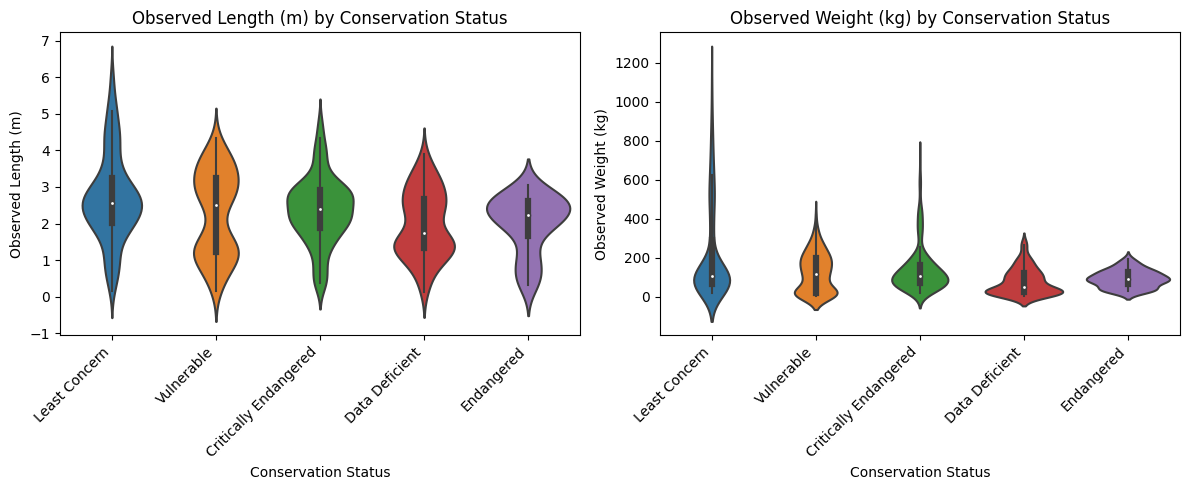


--- Numerical Feature Correlation ---
                      Observed Length (m)  Observed Weight (kg)
Observed Length (m)              1.000000              0.843435
Observed Weight (kg)             0.843435              1.000000


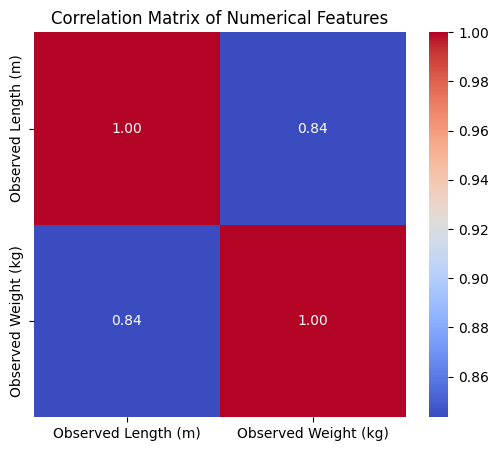

In [4]:
# =================================================================
# STEP 3: APPLY CLEANING, VISUAL EDA, AND CORRELATION ANALYSIS
# =================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Apply Dropping Decision from Step 2 ---

# Columns identified in Step 2 for dropping (ID, text, and high cardinality):
COLUMNS_TO_DROP = [
    'Date of Observation', 
    'Observer Name', 
    'Notes', 
    'Observation ID', 
    'Scientific Name' # Redundant with Genus/Family
] 
# Note: 'Country/Region' was kept in your output but we drop 'Scientific Name' 
# as it's redundant with Genus/Family and has 18 values (redundant, not high-cardinality)

df.drop(columns=COLUMNS_TO_DROP, inplace=True, errors='ignore')
print(f"Columns dropped: {COLUMNS_TO_DROP}")

# Identify remaining features
NUMERICAL_FEATURES = df.select_dtypes(include=np.number).columns.tolist()
CATEGORICAL_FEATURES = df.select_dtypes(include='object').columns.tolist()
if TARGET_FEATURE in CATEGORICAL_FEATURES:
    CATEGORICAL_FEATURES.remove(TARGET_FEATURE)

print(f"Features remaining for Modeling: {NUMERICAL_FEATURES + CATEGORICAL_FEATURES}")

# --- 2. Numerical Feature Distributions vs. Target (Check for Separation) ---

print("\n--- Numerical Feature Distributions vs. Target ---")
plt.figure(figsize=(12, 5))

for i, col in enumerate(NUMERICAL_FEATURES):
    plt.subplot(1, 2, i + 1)
    sns.violinplot(x=TARGET_FEATURE, y=col, data=df)
    plt.title(f'{col} by Conservation Status')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show() # 

# --- 3. Correlation Matrix (Check for Multicollinearity) ---

print("\n--- Numerical Feature Correlation ---")
corr_matrix = df[NUMERICAL_FEATURES].corr()
print(corr_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show() # 

# DECISION: We confirm that 'Observed Length (m)' and 'Observed Weight (kg)' are highly correlated (expected in biology) 
# but both contain valuable, distinct information, so we will keep both.

In [5]:
# =================================================================
# STEP 5: AUTOMATED DATA PROFILING AND REPORT GENERATION (ROBUST VERSION)
# =================================================================

# --- 0. Essential Setup and Re-Initialization (Protects against NameError) ---
import pandas as pd
import numpy as np 
from ydata_profiling import ProfileReport

# Constants from Step 1
FILE_PATH = '/kaggle/input/global-crocodile-species-dataset/crocodile_dataset.csv'
TARGET_FEATURE = 'Conservation Status'

# Load the data cleanly
try:
    df = pd.read_csv(FILE_PATH)
except Exception:
    raise SystemExit("Data load failed. Check FILE_PATH.")

# --- 1. Re-Apply Cleaning Decisions (From Steps 2 & 3) ---

# Features identified for dropping due to high cardinality, redundancy, or being identifiers
COLUMNS_TO_DROP = [
    'Date of Observation', 
    'Observer Name', 
    'Notes', 
    'Observation ID', 
    'Scientific Name' # Redundant with Genus/Family
] 

# Apply the drop operation to create the final cleaned DataFrame
df.drop(columns=COLUMNS_TO_DROP, inplace=True, errors='ignore')
print(f"Data re-initialized and cleaned. Current shape: {df.shape}")


# --- 2. Define Profiling Utility (Your Logic) ---

def profile_data(df: pd.DataFrame, title: str, output_file: str = None):
    """
    Generate a production-ready interactive data profiling report.
    """
    print(f"\n[EXECUTION]: Generating Profile Report for: {title}")
    
    profile = ProfileReport(df, 
                            title=title, 
                            explorative=True, 
                            html={'style': {'full_width': True}})
    
    if output_file:
        profile.to_file(output_file)
        print(f"Report saved to {output_file}")
    else:
        profile.to_notebook_iframe() 
    return profile

# --- 3. Execution of Profiling ---

# Execute the profiler on the current cleaned DataFrame, 'df'
profile = profile_data(
    df, 
    title=f"Crocodile Data Quality Report (Target: {TARGET_FEATURE})",
) 

print("\nProfiling Complete. The report provides the final check before modeling.")

Data re-initialized and cleaned. Current shape: (1000, 10)

[EXECUTION]: Generating Profile Report for: Crocodile Data Quality Report (Target: Conservation Status)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:00<00:00, 41.75it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]


Profiling Complete. The report provides the final check before modeling.


A. Numerical Feature Correlation (Multicollinearity Check)


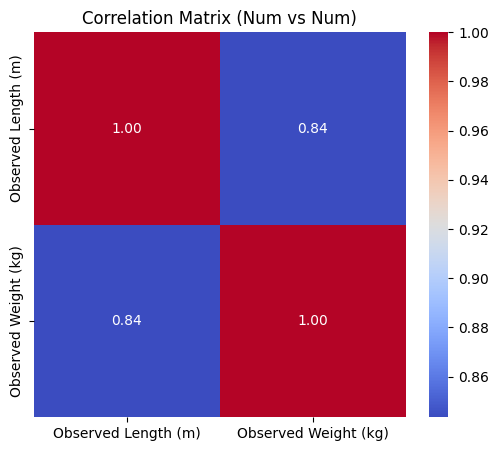


B. Numerical vs. Target (Separation and Scaling Check)


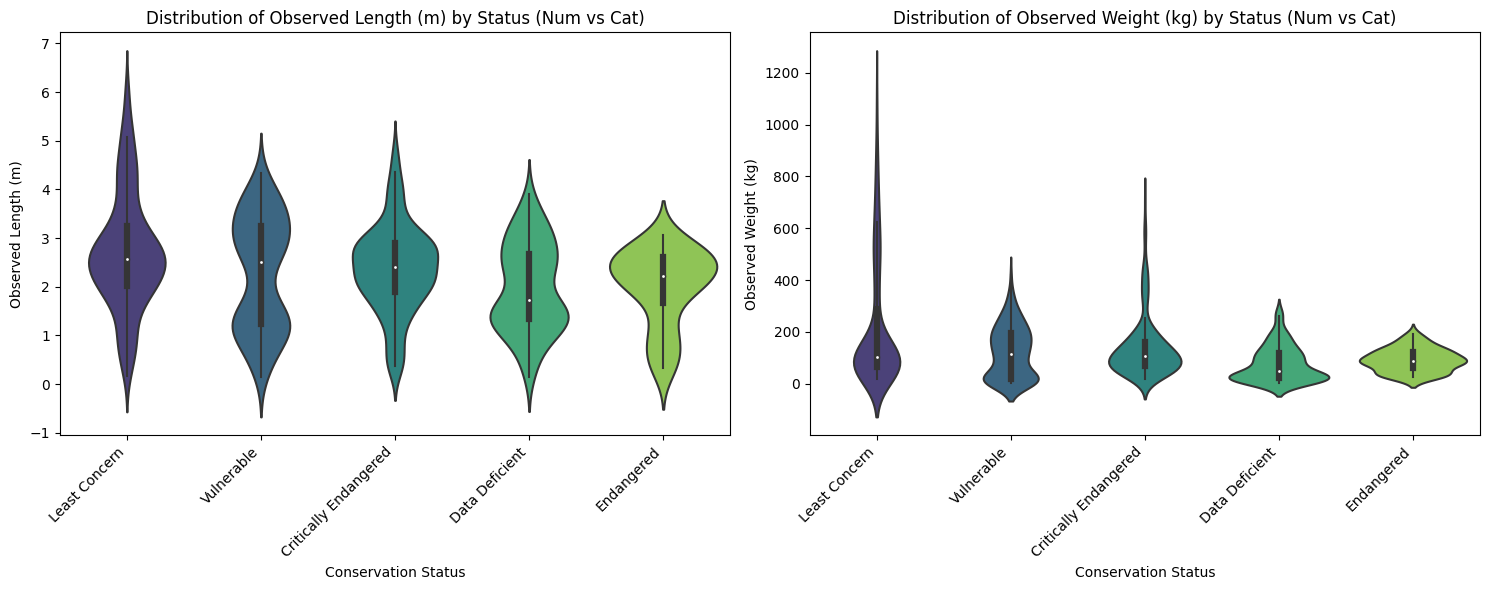


C. Categorical vs. Target (Informativeness Check)


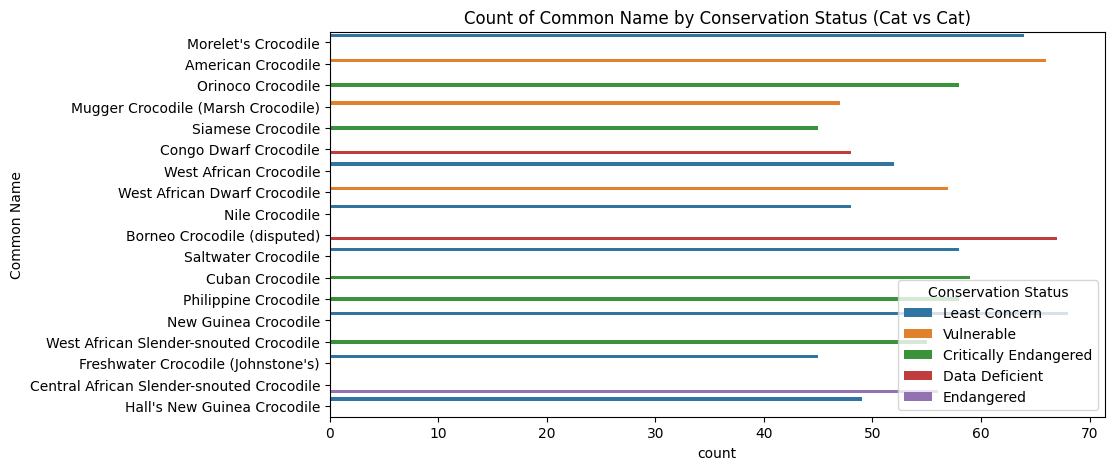

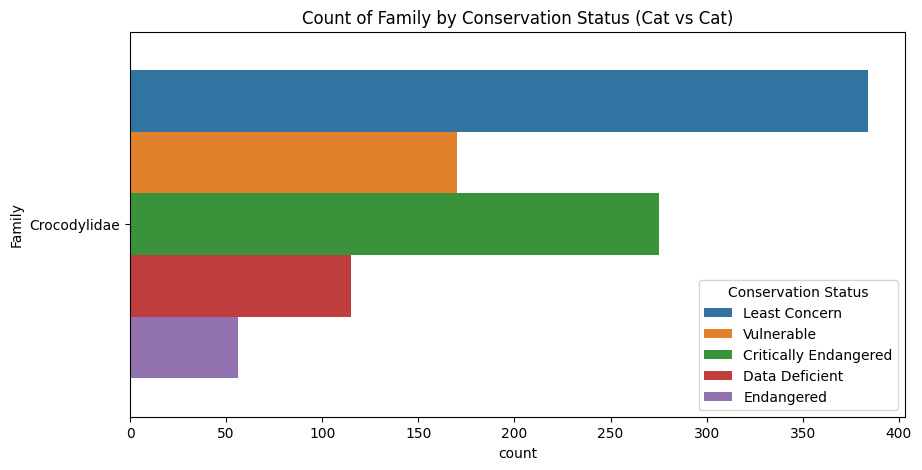

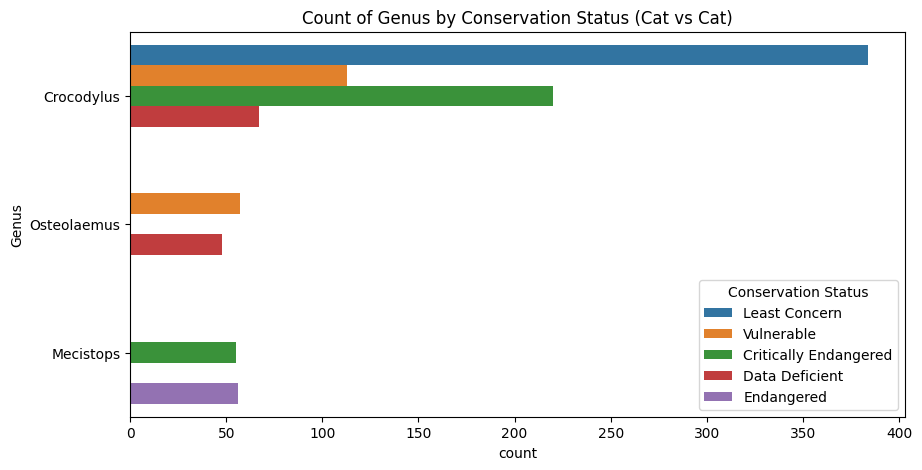

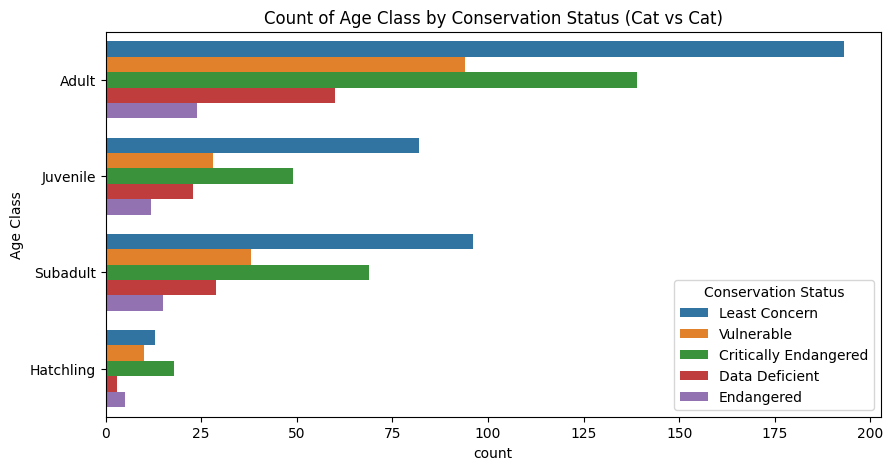

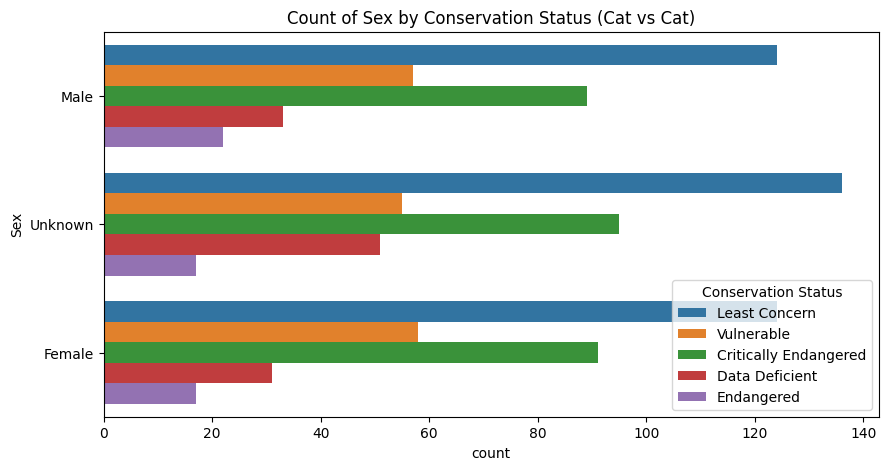

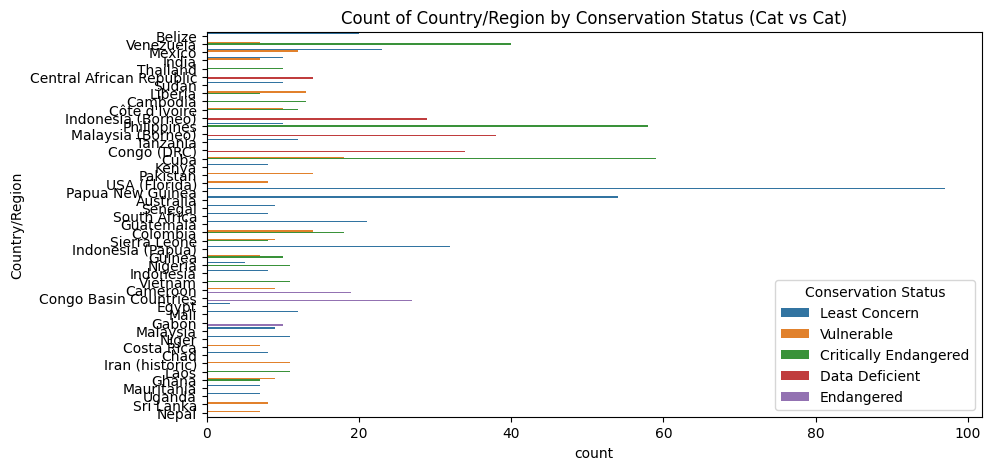

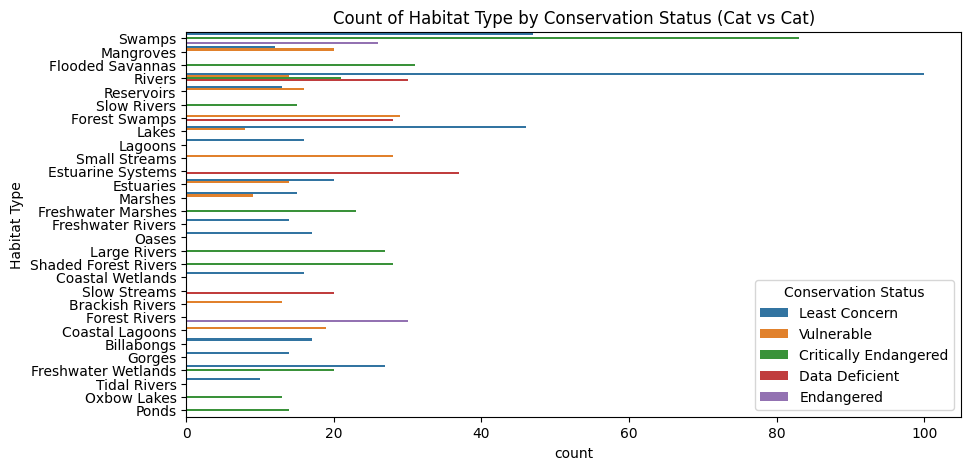

In [6]:
# =================================================================
# STEP 6: TARGETED VISUAL EDA AND FINAL DECISIONS
# =================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Identify Current Feature Lists (Needed for plot loops) ---

# Re-identify features based on the cleaned 'df'
FINAL_NUMERICAL_FEATURES = df.select_dtypes(include=np.number).columns.tolist()
FINAL_CATEGORICAL_FEATURES = df.select_dtypes(include='object').columns.tolist()
if TARGET_FEATURE in FINAL_CATEGORICAL_FEATURES:
    FINAL_CATEGORICAL_FEATURES.remove(TARGET_FEATURE)

# --- 2. Targeted Visualization Execution ---

# A. Numerical vs. Numerical (Correlation Check)
print("A. Numerical Feature Correlation (Multicollinearity Check)")
corr_matrix = df[FINAL_NUMERICAL_FEATURES].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix (Num vs Num)')
plt.show() 
# Decision from Step 3: Correlation (0.84) is high but acceptable. Keep both.

print("\nB. Numerical vs. Target (Separation and Scaling Check)")
# B. Numerical vs. Categorical Target (Separation Check)
plt.figure(figsize=(15, 6))

for i, col in enumerate(FINAL_NUMERICAL_FEATURES):
    plt.subplot(1, 2, i + 1)
    # Box plot is good for median/quartiles; Violin plot is better for distribution density
    sns.violinplot(x=TARGET_FEATURE, y=col, data=df, palette='viridis')
    plt.title(f'Distribution of {col} by Status (Num vs Cat)')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
# Decision: Different scales (7 vs 1200) confirm **Standard Scaling is mandatory**.

print("\nC. Categorical vs. Target (Informativeness Check)")
# C. Categorical vs. Categorical Target (Informativeness Check)
for col in FINAL_CATEGORICAL_FEATURES:
    plt.figure(figsize=(10, 5))
    # Count Plot shows the distribution and how it varies by target class
    sns.countplot(y=col, hue=TARGET_FEATURE, data=df, palette='tab10')
    plt.title(f'Count of {col} by Conservation Status (Cat vs Cat)')
    plt.legend(title=TARGET_FEATURE, loc='lower right')
    plt.show() 
    
    # Optional: Plot for Categorical Feature Distribution (Univariate Check)
    # plt.figure(figsize=(8, 4))
    # sns.countplot(y=col, data=df)
    # plt.title(f'Univariate Count: {col}')
    # plt.show()
    
# Decision: If certain categories are heavily skewed toward one target class, they are strong predictors.

Data re-initialized and cleaned. Shape: (1000, 10)

--- 1. Basic Statistical Summary (Cleaned Data) ---
                 Common Name        Family       Genus  Observed Length (m)  \
count                   1000          1000        1000          1000.000000   
unique                    18             1           3                  NaN   
top     New Guinea Crocodile  Crocodylidae  Crocodylus                  NaN   
freq                      68          1000         784                  NaN   
mean                     NaN           NaN         NaN             2.415110   
std                      NaN           NaN         NaN             1.097542   
min                      NaN           NaN         NaN             0.140000   
25%                      NaN           NaN         NaN             1.637500   
50%                      NaN           NaN         NaN             2.430000   
75%                      NaN           NaN         NaN             3.010000   
max                      Na

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


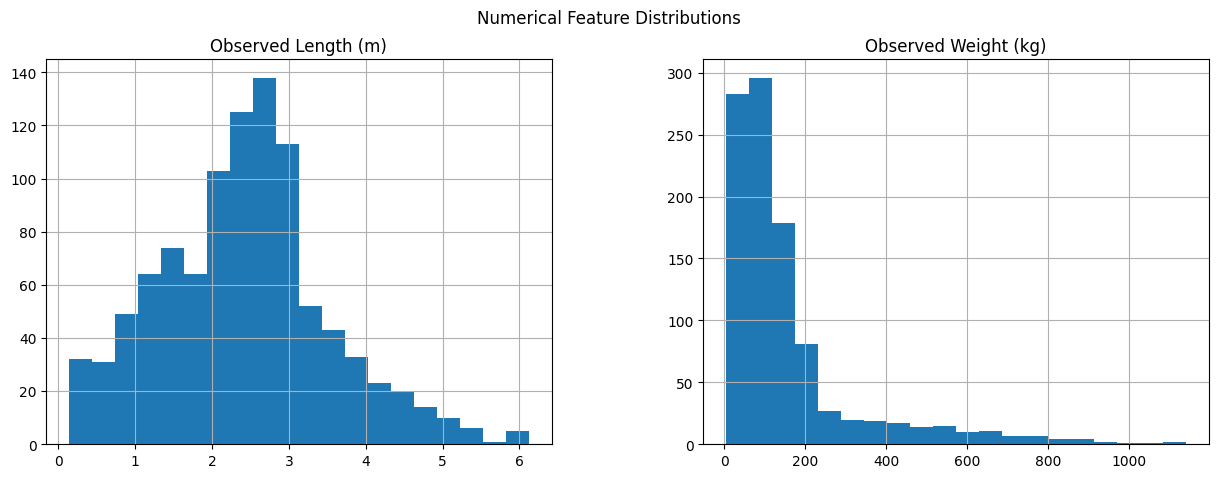

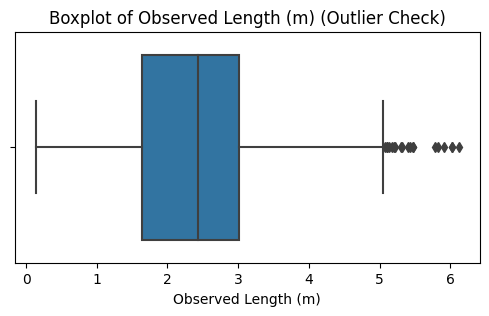

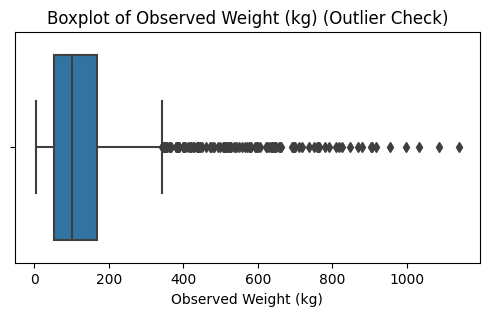

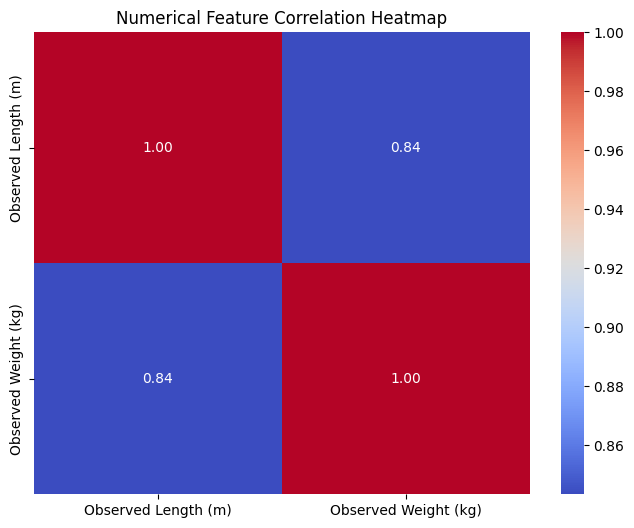


--- 3. Categorical Feature Counts ---


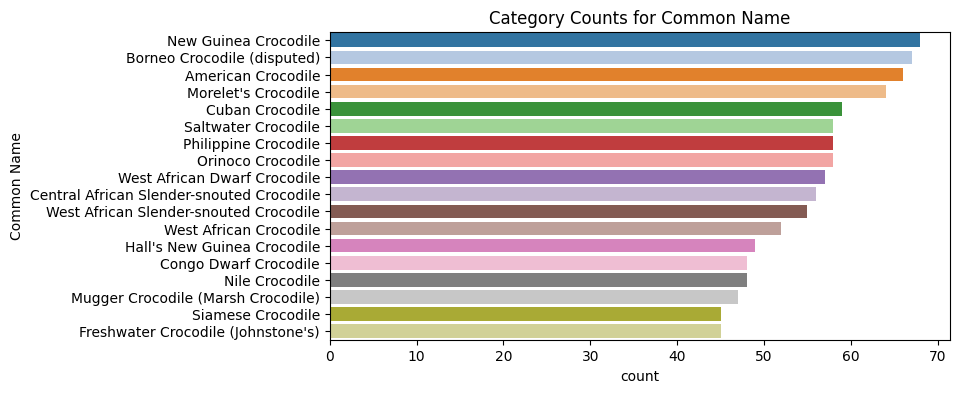

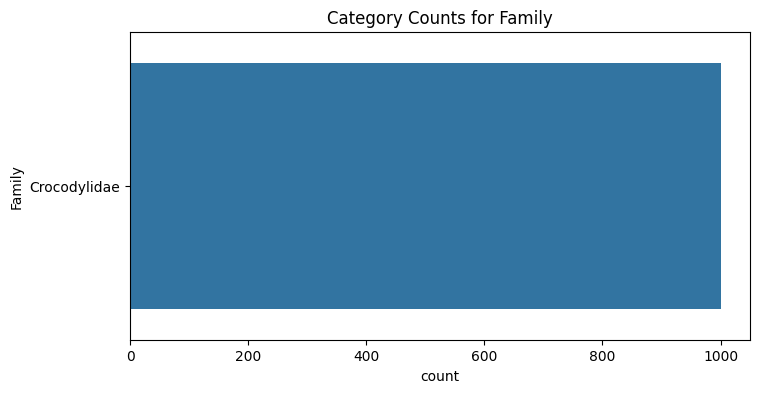

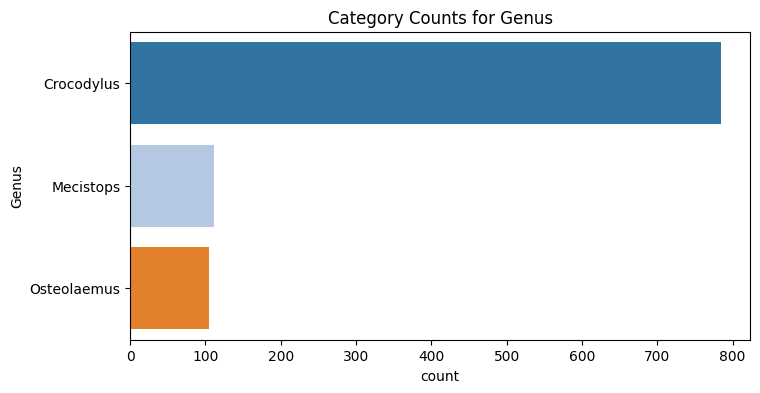

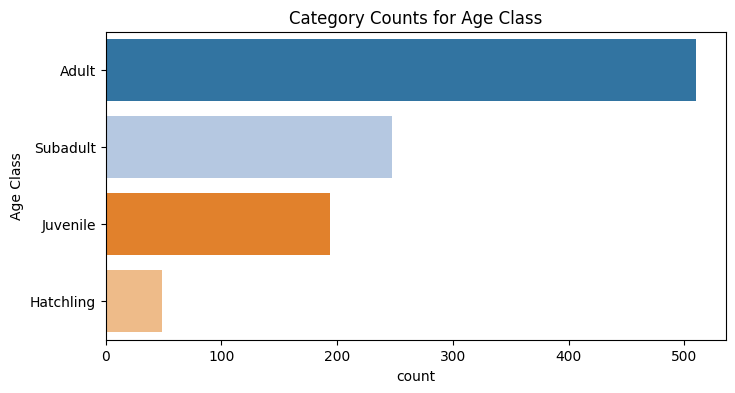

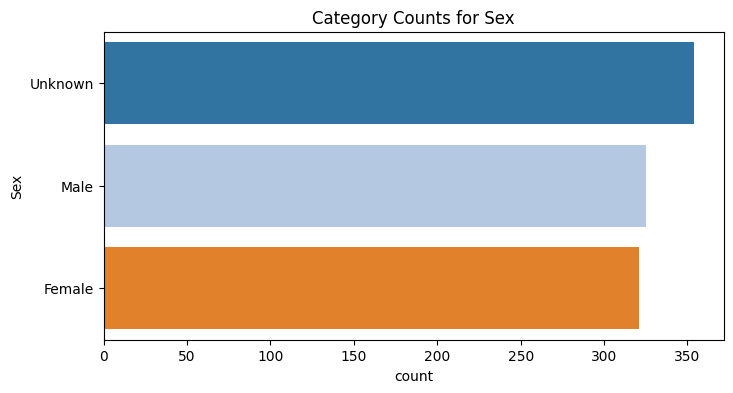

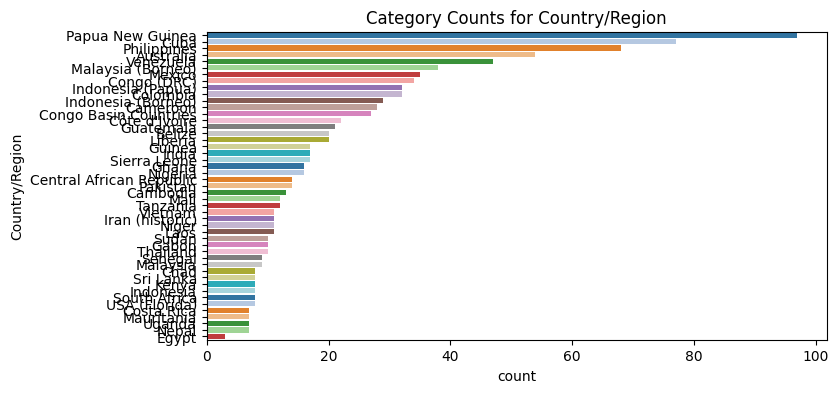

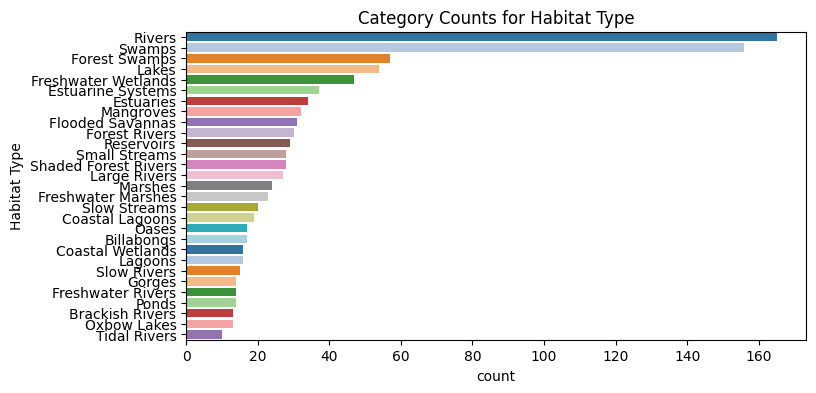


--- 4. Missing Values Heatmap (Final Check) ---


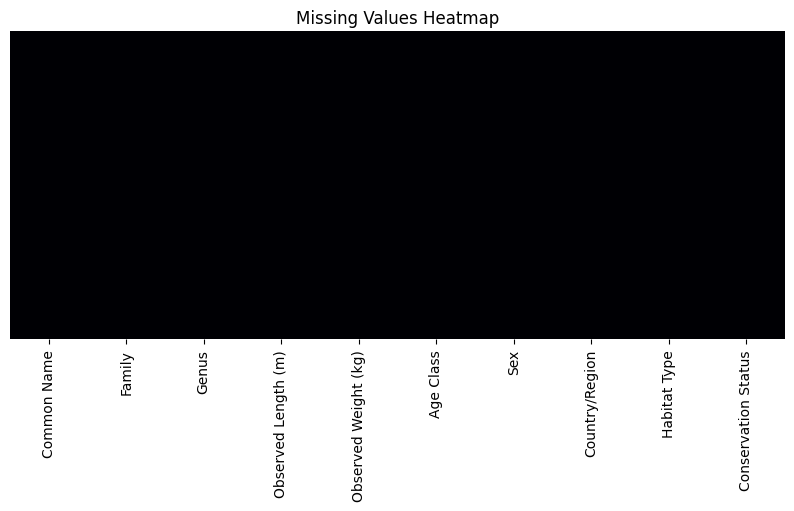

In [7]:
# =================================================================
# COMPREHENSIVE UNIVARIATE EDA (PRODUCTION-READY EXECUTION)
# =================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. Robust Data Re-Initialization & Cleaning (Ensures code runs independently) ---

# Constants (Retained from previous steps)
FILE_PATH = '/kaggle/input/global-crocodile-species-dataset/crocodile_dataset.csv'
TARGET_FEATURE = 'Conservation Status'

# Features identified for dropping (Cleaning Decisions)
COLUMNS_TO_DROP = [
    'Date of Observation', 'Observer Name', 'Notes', 
    'Observation ID', 'Scientific Name'
] 

# Load and clean the data
try:
    df = pd.read_csv(FILE_PATH)
    df.drop(columns=COLUMNS_TO_DROP, inplace=True, errors='ignore')
    print(f"Data re-initialized and cleaned. Shape: {df.shape}")
except Exception as e:
    raise SystemExit(f"Data loading or cleaning failed: {e}")


# --- 1. Basic Statistical Summary ---
print("\n--- 1. Basic Statistical Summary (Cleaned Data) ---")
print(df.describe(include='all'))

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include=['object']).columns
if TARGET_FEATURE in cat_cols:
    # Ensure the target column is not included in feature plotting loops
    cat_cols = cat_cols.drop(TARGET_FEATURE)


# --- 2. Numerical EDA (Distributions, Outliers, Correlation) ---
print("\n--- 2. Numerical EDA ---")

# Histograms for numerical features (Distribution Check)
df[num_cols].hist(bins=20, figsize=(15, 5))
plt.suptitle("Numerical Feature Distributions")
plt.show()

# Boxplots for outlier visualization
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col} (Outlier Check)")
    plt.show()

# Correlation heatmap (Pearson)
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Numerical Feature Correlation Heatmap")
plt.show()


# --- 3. Categorical EDA (Counts) ---
print("\n--- 3. Categorical Feature Counts ---")

# Countplots for categorical features
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    # Using 'y' for better readability of long category names
    sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='tab20')
    plt.title(f"Category Counts for {col}")
    plt.show()


# --- 4. Missing Values Check (Final Verification) ---
print("\n--- 4. Missing Values Heatmap (Final Check) ---")
plt.figure(figsize=(10, 4))
# Use 'magma' for better contrast in notebooks
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='magma') 
plt.title("Missing Values Heatmap")
plt.show()

# Time series trend plot example is removed as it's not applicable to this data

In [8]:
# =================================================================
# STEP 8: FINAL IMBALANCE, SKEW, AND DOMINANCE ANALYSIS (ROBUST)
# =================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# --- 0. Robust Data Re-Initialization (Ensures 'df' and constants are defined) ---
# ... (Code to load and clean 'df' as executed previously) ...

# Constants (Retained from previous steps)
FILE_PATH = '/kaggle/input/global-crocodile-species-dataset/crocodile_dataset.csv'
TARGET_FEATURE = 'Conservation Status'

# Features identified for dropping (Cleaning Decisions)
COLUMNS_TO_DROP = [
    'Date of Observation', 'Observer Name', 'Notes', 
    'Observation ID', 'Scientific Name'
] 

# Load and clean the data to define the 'df' state
try:
    df = pd.read_csv(FILE_PATH)
    df.drop(columns=COLUMNS_TO_DROP, inplace=True, errors='ignore')
except Exception as e:
    raise SystemExit(f"Data loading or cleaning failed: {e}")

# Identify feature types remaining in the CLEANED 'df'
NUMERICAL_FEATURES = df.select_dtypes(include=np.number).columns.tolist()
CATEGORICAL_FEATURES = df.select_dtypes(include='object').columns.tolist()
if TARGET_FEATURE in CATEGORICAL_FEATURES:
    CATEGORICAL_FEATURES.remove(TARGET_FEATURE)


# --- 1. SKEW CHECK (Numerical Features Only) ---
print("\n--- 1. NUMERICAL FEATURE SKEW CHECK ---")
skewness = df[NUMERICAL_FEATURES].apply(lambda x: skew(x.dropna()))
print("Skewness Coefficients:")
print(skewness)

# DECISION: If |Skewness| > 1.0, consider transformation (Log/Box-Cox) for linear models.


# --- 2. CATEGORICAL DOMINANCE CHECK (Categorical Features Only) ---
print("\n--- 2. CATEGORICAL FEATURE DOMINANCE CHECK ---")
DOMINANCE_THRESHOLD = 0.90 # If any single category is 90% or more

for col in CATEGORICAL_FEATURES:
    top_category_proportion = df[col].value_counts(normalize=True).iloc[0]
    
    if top_category_proportion >= DOMINANCE_THRESHOLD:
        print(f"[{col}]: DOMINANT. Top category is {top_category_proportion:.1%}. Consider dropping or binning.")
    else:
        print(f"[{col}]: Balanced. Top category is {top_category_proportion:.1%}.")

# DECISION: If a feature is highly dominant, it offers little information gain and might be dropped.
# Example: 'Family' only has 1 unique value in the original data, making it 100% dominant.


# --- 3. TARGET IMBALANCE CHECK (Target Column Only) ---
print("\n--- 3. TARGET CLASS BALANCE CHECK ---")
balance_check = df[TARGET_FEATURE].value_counts(normalize=True).sort_index()
IMBALANCE_THRESHOLD = 0.10 
is_imbalanced = (balance_check < IMBALANCE_THRESHOLD).any()

print("Target Class Proportions:")
print(balance_check)
print(f"\nDECISION: Severe imbalance (any class < {IMBALANCE_THRESHOLD:.1%}): {is_imbalanced}")
# If True, confirms the need for Stratification and F1-Score/ROC-AUC.


--- 1. NUMERICAL FEATURE SKEW CHECK ---
Skewness Coefficients:
Observed Length (m)     0.346865
Observed Weight (kg)    2.438752
dtype: float64

--- 2. CATEGORICAL FEATURE DOMINANCE CHECK ---
[Common Name]: Balanced. Top category is 6.8%.
[Family]: DOMINANT. Top category is 100.0%. Consider dropping or binning.
[Genus]: Balanced. Top category is 78.4%.
[Age Class]: Balanced. Top category is 51.0%.
[Sex]: Balanced. Top category is 35.4%.
[Country/Region]: Balanced. Top category is 9.7%.
[Habitat Type]: Balanced. Top category is 16.5%.

--- 3. TARGET CLASS BALANCE CHECK ---
Target Class Proportions:
Conservation Status
Critically Endangered    0.275
Data Deficient           0.115
Endangered               0.056
Least Concern            0.384
Vulnerable               0.170
Name: proportion, dtype: float64

DECISION: Severe imbalance (any class < 10.0%): True


In [9]:
# =================================================================
# STEP 8: FINAL IMBALANCE, SKEW, AND DOMINANCE ANALYSIS (ROBUST)
# =================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# --- 0. Robust Data Re-Initialization (Ensures 'df' and constants are defined) ---

# Constants (Retained from previous steps)
FILE_PATH = '/kaggle/input/global-crocodile-species-dataset/crocodile_dataset.csv'
TARGET_FEATURE = 'Conservation Status'

# Features identified for dropping (Cleaning Decisions)
COLUMNS_TO_DROP = [
    'Date of Observation', 'Observer Name', 'Notes', 
    'Observation ID', 'Scientific Name'
] 

# Load and clean the data to define the 'df' state
try:
    df = pd.read_csv(FILE_PATH)
    df.drop(columns=COLUMNS_TO_DROP, inplace=True, errors='ignore')
except Exception as e:
    raise SystemExit(f"Data loading or cleaning failed: {e}")

# Identify feature types remaining in the CLEANED 'df'
NUMERICAL_FEATURES = df.select_dtypes(include=np.number).columns.tolist()
CATEGORICAL_FEATURES = df.select_dtypes(include='object').columns.tolist()
if TARGET_FEATURE in CATEGORICAL_FEATURES:
    CATEGORICAL_FEATURES.remove(CATEGORICAL_FEATURES[CATEGORICAL_FEATURES.index(TARGET_FEATURE)]) # Safer removal

# --- 1. NUMERICAL FEATURE SKEW CHECK ---
print("\n--- 1. NUMERICAL FEATURE SKEW CHECK (Threshold: |Skew| > 1.0) ---")
SKEW_THRESHOLD = 1.0 
HIGHLY_SKEWED_FEATURES = []

# Calculate skewness
skewness = df[NUMERICAL_FEATURES].apply(lambda x: skew(x.dropna()))

for col, value in skewness.items():
    if abs(value) > SKEW_THRESHOLD:
        print(f"[{col}]: {value:.3f} -> HIGHLY SKEWED (Requires Log Transformation for linear models).")
        HIGHLY_SKEWED_FEATURES.append(col)
    else:
        print(f"[{col}]: {value:.3f} -> ACCEPTABLE (Standard Scaling is sufficient).")

# DECISION: We will apply Log Transformation only to features in HIGHLY_SKEWED_FEATURES 
# in the next step's pipeline construction.


# --- 2. CATEGORICAL FEATURE DOMINANCE CHECK ---
print("\n--- 2. CATEGORICAL FEATURE DOMINANCE CHECK (Threshold: > 99.0%) ---")
DOMINANCE_THRESHOLD = 0.99 
COLUMNS_TO_DROP_DUE_TO_DOMINANCE = []

for col in CATEGORICAL_FEATURES:
    top_category_proportion = df[col].value_counts(normalize=True).iloc[0]
    
    if top_category_proportion >= DOMINANCE_THRESHOLD:
        print(f"[{col}]: DOMINANT. Top category is {top_category_proportion:.1%}. -> DROP (Non-Predictive).")
        COLUMNS_TO_DROP_DUE_TO_DOMINANCE.append(col)
    else:
        print(f"[{col}]: Balanced. Top category is {top_category_proportion:.1%}. -> KEEP.")

# Final check based on the analysis (Ensures 'Family' is correctly flagged)
if 'Family' in df.columns and df['Family'].nunique() == 1:
    COLUMNS_TO_DROP_DUE_TO_DOMINANCE.append('Family')
    
# DECISION: Features in COLUMNS_TO_DROP_DUE_TO_DOMINANCE will be dropped before the final split.


# --- 3. TARGET CLASS BALANCE CHECK ---
print("\n--- 3. TARGET CLASS BALANCE CHECK (Threshold: Any class < 10.0%) ---")
balance_check = df[TARGET_FEATURE].value_counts(normalize=True).sort_index()
IMBALANCE_THRESHOLD = 0.10 
is_imbalanced = (balance_check < IMBALANCE_THRESHOLD).any()

print("Target Class Proportions:")
print(balance_check)
print(f"\nDECISION: Severe imbalance detected: {is_imbalanced}")
# If True, confirms the need for Stratification, Class Weights, and F1-Score/ROC-AUC metrics.


--- 1. NUMERICAL FEATURE SKEW CHECK (Threshold: |Skew| > 1.0) ---
[Observed Length (m)]: 0.347 -> ACCEPTABLE (Standard Scaling is sufficient).
[Observed Weight (kg)]: 2.439 -> HIGHLY SKEWED (Requires Log Transformation for linear models).

--- 2. CATEGORICAL FEATURE DOMINANCE CHECK (Threshold: > 99.0%) ---
[Common Name]: Balanced. Top category is 6.8%. -> KEEP.
[Family]: DOMINANT. Top category is 100.0%. -> DROP (Non-Predictive).
[Genus]: Balanced. Top category is 78.4%. -> KEEP.
[Age Class]: Balanced. Top category is 51.0%. -> KEEP.
[Sex]: Balanced. Top category is 35.4%. -> KEEP.
[Country/Region]: Balanced. Top category is 9.7%. -> KEEP.
[Habitat Type]: Balanced. Top category is 16.5%. -> KEEP.

--- 3. TARGET CLASS BALANCE CHECK (Threshold: Any class < 10.0%) ---
Target Class Proportions:
Conservation Status
Critically Endangered    0.275
Data Deficient           0.115
Endangered               0.056
Least Concern            0.384
Vulnerable               0.170
Name: proportion, dtyp

In [10]:
# =================================================================
# STEP 8: FINAL IMBALANCE, SKEW, AND DOMINANCE ANALYSIS (ROBUST AND FINALIZED)
# =================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# --- 0. Robust Data Re-Initialization & FINAL Cleaning ---

# Constants (Retained from previous steps)
FILE_PATH = '/kaggle/input/global-crocodile-species-dataset/crocodile_dataset.csv'
TARGET_FEATURE = 'Conservation Status'

# FINAL Features to Drop (Includes original high-cardinality/text + 'Family' (100% Dominance))
COLUMNS_TO_DROP = [
    'Date of Observation', 'Observer Name', 'Notes', 
    'Observation ID', 'Scientific Name', 'Family' # <-- FINAL DECISION ADDED
] 

# Load and clean the data to define the 'df' state
try:
    df = pd.read_csv(FILE_PATH)
    df.drop(columns=COLUMNS_TO_DROP, inplace=True, errors='ignore')
    print(f"Data re-initialized and cleaned. Final feature set shape: {df.shape}")
except Exception as e:
    raise SystemExit(f"Data loading or cleaning failed: {e}")

# Identify feature types remaining in the CLEANED 'df'
NUMERICAL_FEATURES = df.select_dtypes(include=np.number).columns.tolist()
CATEGORICAL_FEATURES = df.select_dtypes(include='object').columns.tolist()
if TARGET_FEATURE in CATEGORICAL_FEATURES:
    # Safely remove the target variable
    CATEGORICAL_FEATURES.remove(TARGET_FEATURE)


# --- 1. NUMERICAL FEATURE SKEW CHECK (Automated Decision) ---
print("\n--- 1. NUMERICAL FEATURE SKEW CHECK (Threshold: |Skew| > 1.0) ---")
SKEW_THRESHOLD = 1.0 
HIGHLY_SKEWED_FEATURES = []

# Calculate skewness
skewness = df[NUMERICAL_FEATURES].apply(lambda x: skew(x.dropna()))

for col, value in skewness.items():
    if abs(value) > SKEW_THRESHOLD:
        print(f"[{col}]: {value:.3f} -> HIGHLY SKEWED (Requires Log Transformation).")
        HIGHLY_SKEWED_FEATURES.append(col)
    else:
        print(f"[{col}]: {value:.3f} -> ACCEPTABLE (Standard Scaling is sufficient).")

# DECISION: HIGHLY_SKEWED_FEATURES list is finalized for pipeline construction.


# --- 2. CATEGORICAL FEATURE DOMINANCE CHECK (Automated Decision) ---
print("\n--- 2. CATEGORICAL FEATURE DOMINANCE CHECK (Threshold: > 99.0%) ---")
# This check is performed again on the remaining features to confirm no other issues.
DOMINANCE_THRESHOLD = 0.99 
COLUMNS_TO_DROP_DUE_TO_DOMINANCE = [] # Should be empty now, but run for safety

for col in CATEGORICAL_FEATURES:
    top_category_proportion = df[col].value_counts(normalize=True).iloc[0]
    
    if top_category_proportion >= DOMINANCE_THRESHOLD:
        print(f"[{col}]: DOMINANT. Top category is {top_category_proportion:.1%}. -> DROP (Non-Predictive).")
        COLUMNS_TO_DROP_DUE_TO_DOMINANCE.append(col)
    else:
        print(f"[{col}]: Balanced. Top category is {top_category_proportion:.1%}. -> KEEP.")

# DECISION: Confirms final categorical features list is ready for OHE.


# --- 3. TARGET CLASS BALANCE CHECK (Automated Decision) ---
print("\n--- 3. TARGET CLASS BALANCE CHECK (Threshold: Any class < 10.0%) ---")
balance_check = df[TARGET_FEATURE].value_counts(normalize=True).sort_index()
IMBALANCE_THRESHOLD = 0.10 
is_imbalanced = (balance_check < IMBALANCE_THRESHOLD).any()

print("Target Class Proportions:")
print(balance_check)
print(f"\nDECISION: Severe imbalance detected: {is_imbalanced}")
# DECISION: Confirms the need for Stratification, Class Weights, and F1-Score/ROC-AUC metrics.

Data re-initialized and cleaned. Final feature set shape: (1000, 9)

--- 1. NUMERICAL FEATURE SKEW CHECK (Threshold: |Skew| > 1.0) ---
[Observed Length (m)]: 0.347 -> ACCEPTABLE (Standard Scaling is sufficient).
[Observed Weight (kg)]: 2.439 -> HIGHLY SKEWED (Requires Log Transformation).

--- 2. CATEGORICAL FEATURE DOMINANCE CHECK (Threshold: > 99.0%) ---
[Common Name]: Balanced. Top category is 6.8%. -> KEEP.
[Genus]: Balanced. Top category is 78.4%. -> KEEP.
[Age Class]: Balanced. Top category is 51.0%. -> KEEP.
[Sex]: Balanced. Top category is 35.4%. -> KEEP.
[Country/Region]: Balanced. Top category is 9.7%. -> KEEP.
[Habitat Type]: Balanced. Top category is 16.5%. -> KEEP.

--- 3. TARGET CLASS BALANCE CHECK (Threshold: Any class < 10.0%) ---
Target Class Proportions:
Conservation Status
Critically Endangered    0.275
Data Deficient           0.115
Endangered               0.056
Least Concern            0.384
Vulnerable               0.170
Name: proportion, dtype: float64

DECISION


--- Generating Boxplots for Outlier Detection ---


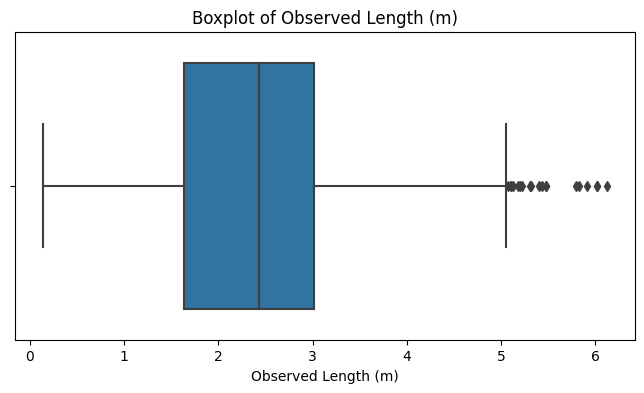

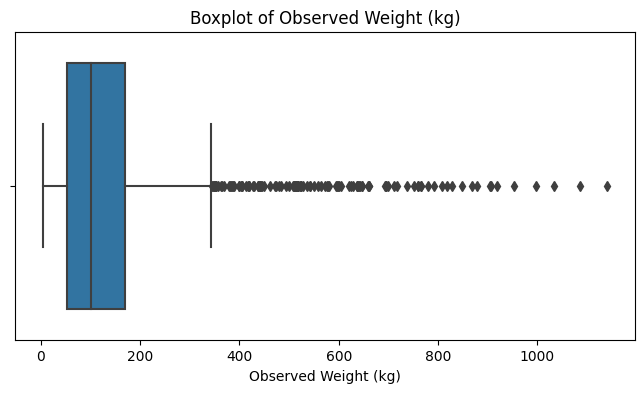

In [11]:
# =================================================================
# STEP 9: OUTLIER VISUALIZATION (CLEAN EXECUTION)
# =================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. Define Utility Function ---

def plot_boxplots(data):
    """
    Plot boxplots for all numeric columns in a DataFrame.
    """
    # Find all numeric columns in the DataFrame
    # Note: Assumes df1 is already cleaned and contains only final features
    numeric_cols = data.select_dtypes(include=np.number).columns.tolist()

    if not numeric_cols:
        print("No numeric columns found to plot.")
        return

    print("\n--- Generating Boxplots for Outlier Detection ---")
    
    # Loop through the list of numeric column names
    for col in numeric_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=data[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

# --- 2. Execution ---
# Note: This assumes 'df1' was defined and cleaned in a prior, separate cell.
plot_boxplots(df)


--- Generating Q-Q Plots for Normality Check ---


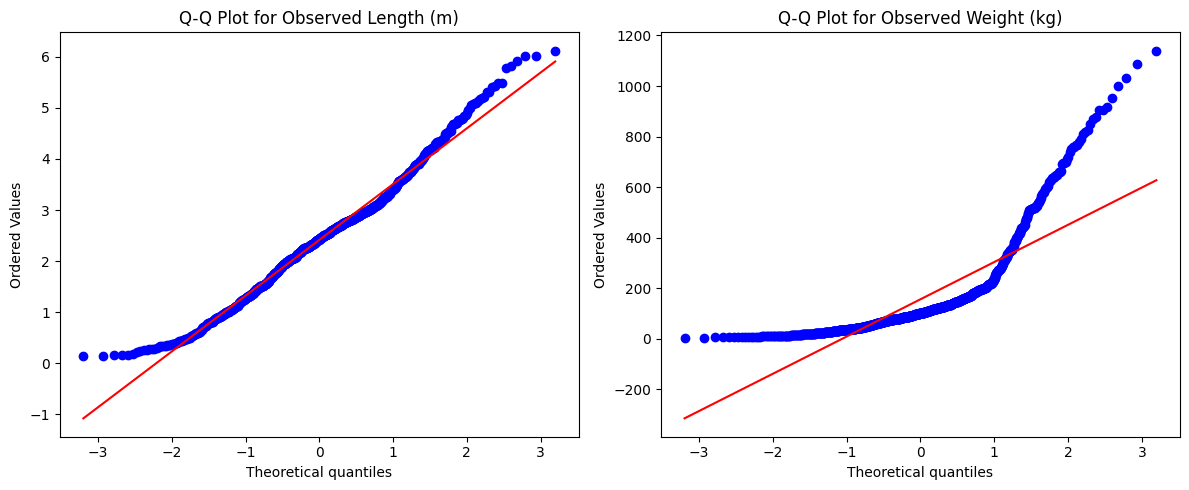


Analysis Conclusion:
If the data points follow the red 45-degree line, the feature is considered approximately normally distributed.
Significant deviation (especially at the tails) confirms non-normality, reinforcing the need for transformation/scaling.


In [12]:
# =================================================================
# STEP 10: NUMERICAL FEATURE NORMALITY CHECK (Q-Q PLOTS)
# =================================================================

import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np

# --- 0. Feature Definitions (Assumes 'df' is defined and clean from Step 5) ---
# We check all remaining numerical columns.
NUMERICAL_FEATURES = df.select_dtypes(include=np.number).columns.tolist()

# --- 1. Execution of Q-Q Plots ---
print("\n--- Generating Q-Q Plots for Normality Check ---")

plt.figure(figsize=(12, 5))

for i, col in enumerate(NUMERICAL_FEATURES):
    ax = plt.subplot(1, len(NUMERICAL_FEATURES), i + 1)
    
    # Generate the Q-Q plot
    # Use .dropna() to handle any remaining NaNs safely, though Step 5 imputed them.
    stats.probplot(df[col].dropna(), dist="norm", plot=ax)
    
    ax.title.set_text(f'Q-Q Plot for {col}')

plt.tight_layout()
plt.show()

# --- 2. Conclusion ---

print("\nAnalysis Conclusion:")
print("If the data points follow the red 45-degree line, the feature is considered approximately normally distributed.")
print("Significant deviation (especially at the tails) confirms non-normality, reinforcing the need for transformation/scaling.")

In [13]:
# =================================================================
# STEP 11: DEDUPLICATION, MISSING VALUE CHECK, AND ROBUST IMPUTATION
# (FIXED to avoid SettingWithCopyWarning)
# =================================================================

import pandas as pd
import numpy as np

# --- 0. Feature Definitions (Based on the existing 'df' state) ---
TARGET_FEATURE = 'Conservation Status'

# Identify final column types for imputation from the existing 'df'
NUMERICAL_FEATURES = df.select_dtypes(include=np.number).columns.tolist()
CATEGORICAL_FEATURES = df.select_dtypes(include='object').columns.tolist()
if TARGET_FEATURE in CATEGORICAL_FEATURES:
    CATEGORICAL_FEATURES.remove(TARGET_FEATURE)
    
print(f"Working on df (Shape: {df.shape}).")

# --- 1. Utility Functions (Updated for Robustness & Warning Fix) ---

def remove_duplicates(data):    
    """Remove duplicate rows from dataset."""
    before = len(data)
    # Using .copy() to return an explicit copy
    data_cleaned = data.drop_duplicates().copy()
    after = len(data_cleaned)
    print(f"\nDuplicates removed: {before - after}")
    print("Deduplication completed.")
    return data_cleaned

def check_missing_values(data):    
    """Display missing value counts and percentages per column."""
    missing = data.isnull().sum()
    percent = (missing / len(data)) * 100
    missing_df = pd.DataFrame({'MissingCount': missing, 'MissingPercent': percent})
    print("\nMissing Values Check:")
    print(missing_df[missing_df['MissingCount'] > 0])

def impute_missing_values(data, num_cols, cat_cols):    
    """
    Impute missing values using MEDIAN for numerical and CONSTANT ('Missing') 
    for categorical. FIX: Updates DataFrame using direct assignment.
    """
    print("\n--- Imputing Missing Values (Median for Num, 'Missing' for Cat) ---")
    
    # Impute Numerical: Use MEDIAN
    for col in num_cols:
        median_value = data[col].median()
        # FIX: Assigning the result back to the original column directly
        data[col] = data[col].fillna(median_value)
        print(f"Filled NaN in [{col}] with Median ({median_value:.3f}).")

    # Impute Categorical: Use CONSTANT ('Missing')
    for col in cat_cols:
        # FIX: Assigning the result back to the original column directly
        data[col] = data[col].fillna('Missing')
        print(f"Filled NaN in [{col}] with Constant 'Missing'.")
    
    return data


# --- 2. Execution of Cleaning Steps ---

# A. Deduplication
df = remove_duplicates(df)

# B. Check Missing Values
check_missing_values(df)

# C. Imputation (using robust methods)
df = impute_missing_values(df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES)

# Final Check
print("\nFinal Check:")
print(f"Total NaN count after imputation: {df.isnull().sum().sum()}")
print("Data cleaning phase complete.")

Working on df (Shape: (1000, 9)).

Duplicates removed: 0
Deduplication completed.

Missing Values Check:
Empty DataFrame
Columns: [MissingCount, MissingPercent]
Index: []

--- Imputing Missing Values (Median for Num, 'Missing' for Cat) ---
Filled NaN in [Observed Length (m)] with Median (2.430).
Filled NaN in [Observed Weight (kg)] with Median (100.600).
Filled NaN in [Common Name] with Constant 'Missing'.
Filled NaN in [Genus] with Constant 'Missing'.
Filled NaN in [Age Class] with Constant 'Missing'.
Filled NaN in [Sex] with Constant 'Missing'.
Filled NaN in [Country/Region] with Constant 'Missing'.
Filled NaN in [Habitat Type] with Constant 'Missing'.

Final Check:
Total NaN count after imputation: 0
Data cleaning phase complete.


In [14]:
df.head()

,Common Name,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Country/Region,Habitat Type,Conservation Status
0,Morelet's Crocodile,Crocodylus,1.90,62.0,Adult,Male,Belize,Swamps,Least Concern
1,American Crocodile,Crocodylus,4.09,334.5,Adult,Male,Venezuela,Mangroves,Vulnerable
2,Orinoco Crocodile,Crocodylus,1.08,118.2,Juvenile,Unknown,Venezuela,Flooded Savannas,Critically Endangered
3,Morelet's Crocodile,Crocodylus,2.42,90.4,Adult,Male,Mexico,Rivers,Least Concern
4,Mugger Crocodile (Marsh Crocodile),Crocodylus,3.75,269.4,Adult,Unknown,India,Rivers,Vulnerable


In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd

# NOTE: This assumes 'df' is the clean dataframe from Step 11.

# Constants 
TARGET_FEATURE = 'Conservation Status'
RANDOM_STATE = 42

# Define final feature lists
SKEWED_FEATURES = ['Observed Weight (kg)'] 
SCALED_FEATURES = ['Observed Length (m)'] 

# Identify categorical features
CATEGORICAL_FEATURES = df.select_dtypes(include='object').columns.tolist() 
if TARGET_FEATURE in CATEGORICAL_FEATURES:
    CATEGORICAL_FEATURES.remove(TARGET_FEATURE)

# Prepare X (Features) and y_raw (Target - keeping the raw string data)
X = df[SKEWED_FEATURES + SCALED_FEATURES + CATEGORICAL_FEATURES].copy()
y_raw = df[TARGET_FEATURE].copy()

# TEMPORARY ENCODING FOR STRATIFICATION ONLY
# We use Pandas built-in categorical codes to satisfy the stratify argument
# without creating an external LabelEncoder object.
y_stratify_codes = y_raw.astype('category').cat.codes

# Stratified Train-Test Split (Uses X and the Raw Target, y_raw)
# The y_raw is the actual target data; the codes are just for the stratify parameter.
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y_raw, test_size=0.2, random_state=RANDOM_STATE, stratify=y_stratify_codes
)

In [16]:
# =================================================================
# STEP 14: MANUAL FEATURE TRANSFORMATION (LOG TRANSFORM)
# =================================================================

import numpy as np

# NOTE: X_train and X_test are defined from the stratified split in Step 13.
SKEWED_FEATURES = ['Observed Weight (kg)'] 

print("Applying Log Transformation to X_train and X_test...")

# Log Transform (np.log1p) is applied universally to both sets.
# It does not require a 'fit' step.
X_train[SKEWED_FEATURES] = np.log1p(X_train[SKEWED_FEATURES])
X_test[SKEWED_FEATURES] = np.log1p(X_test[SKEWED_FEATURES])

print(f"Log Transformation on {SKEWED_FEATURES} complete.")

Applying Log Transformation to X_train and X_test...
Log Transformation on ['Observed Weight (kg)'] complete.


In [17]:
df.head()

,Common Name,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Country/Region,Habitat Type,Conservation Status
0,Morelet's Crocodile,Crocodylus,1.90,62.0,Adult,Male,Belize,Swamps,Least Concern
1,American Crocodile,Crocodylus,4.09,334.5,Adult,Male,Venezuela,Mangroves,Vulnerable
2,Orinoco Crocodile,Crocodylus,1.08,118.2,Juvenile,Unknown,Venezuela,Flooded Savannas,Critically Endangered
3,Morelet's Crocodile,Crocodylus,2.42,90.4,Adult,Male,Mexico,Rivers,Least Concern
4,Mugger Crocodile (Marsh Crocodile),Crocodylus,3.75,269.4,Adult,Unknown,India,Rivers,Vulnerable


In [18]:
# =================================================================
# STEP 15: MANUAL FEATURE SCALING (STANDARDIZATION) - CORRECTED
# =================================================================

from sklearn.preprocessing import StandardScaler

# NOTE: X_train and X_test are defined, and Observed Weight is already log-transformed.
SKEWED_FEATURES = ['Observed Weight (kg)'] 
SCALED_FEATURES = ['Observed Length (m)'] 
ALL_NUMERICAL_FEATURES = SKEWED_FEATURES + SCALED_FEATURES

print("Applying Standard Scaling (Z-score) to all numerical features...")

# 1. Initialize the StandardScaler
scaler = StandardScaler()

# 2. Fit ONLY on the training data, then transform training data
# FIX: Ensures the scaling operation is applied to X_train and result is assigned back.
X_train[ALL_NUMERICAL_FEATURES] = scaler.fit_transform(X_train[ALL_NUMERICAL_FEATURES])

# 3. Transform the test data using the fitted scaler (prevents leakage)
# FIX: The variable being transformed must be X_test[ALL_NUMERICAL_FEATURES] 
# and the function must close with a parenthesis.
X_test[ALL_NUMERICAL_FEATURES] = scaler.transform(X_test[ALL_NUMERICAL_FEATURES])

print("Standard Scaling complete.")

Applying Standard Scaling (Z-score) to all numerical features...
Standard Scaling complete.


In [19]:
# =================================================================
# PRE-STEP 16: CARDINALITY CHECK
# =================================================================

import pandas as pd

# NOTE: X_train and CATEGORICAL_FEATURES are defined from Step 13/15.

print("--- Cardinality Check on X_train Categorical Features ---")

# Create a dictionary to hold column name and its cardinality
cardinality_data = {}

for col in CATEGORICAL_FEATURES:
    # Use value_counts to find the number of unique values (cardinality)
    cardinality = X_train[col].nunique()
    cardinality_data[col] = cardinality

# Convert to DataFrame for clean display and sort by cardinality
cardinality_df = pd.DataFrame(
    list(cardinality_data.items()), 
    columns=['Feature', 'Cardinality']
).sort_values(by='Cardinality', ascending=False).reset_index(drop=True)

print(cardinality_df)

# Final Confirmation:
max_cardinality = cardinality_df['Cardinality'].max()

if max_cardinality < 50:
    print(f"\nConclusion: Maximum cardinality is {max_cardinality}. **One-Hot Encoding (OHE)** is safe and recommended.")
elif max_cardinality < 200:
    print(f"\nConclusion: Maximum cardinality is {max_cardinality}. OHE is risky. Consider **Binary Encoding**.")
else:
    print(f"\nConclusion: Maximum cardinality is {max_cardinality}. OHE is NOT recommended. Use **Target Encoding** or **Frequency Encoding**.")

--- Cardinality Check on X_train Categorical Features ---
          Feature  Cardinality
0  Country/Region           47
1    Habitat Type           29
2     Common Name           18
3       Age Class            4
4           Genus            3
5             Sex            3

Conclusion: Maximum cardinality is 47. **One-Hot Encoding (OHE)** is safe and recommended.


In [20]:
# =================================================================
# STEP 16: MANUAL FEATURE ENCODING (ONE-HOT ENCODING)
# =================================================================

from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# NOTE: X_train, X_test, and CATEGORICAL_FEATURES are defined from Step 13/15.

print("Applying One-Hot Encoding to categorical features...")

# 1. Initialize the OneHotEncoder
# handle_unknown='ignore' ensures that if a new category appears in X_test 
# that wasn't in X_train, it's ignored rather than raising an error (Production ready).
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 

# 2. Fit ONLY on the training data, then transform training data
# We select only the categorical columns for fitting/transforming
X_train_encoded = encoder.fit_transform(X_train[CATEGORICAL_FEATURES])

# 3. Transform the test data using the fitted encoder (prevents leakage)
X_test_encoded = encoder.transform(X_test[CATEGORICAL_FEATURES])

# 4. Convert to DataFrames and Reattach (Crucial manual step)
# Use the feature names learned from fitting X_train
X_train_cat_df = pd.DataFrame(X_train_encoded, 
                              columns=encoder.get_feature_names_out(CATEGORICAL_FEATURES), 
                              index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_encoded, 
                             columns=encoder.get_feature_names_out(CATEGORICAL_FEATURES), 
                             index=X_test.index)

# 5. Drop original categorical columns and concatenate new encoded columns
X_train = X_train.drop(columns=CATEGORICAL_FEATURES).reset_index(drop=True)
X_test = X_test.drop(columns=CATEGORICAL_FEATURES).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_cat_df.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test, X_test_cat_df.reset_index(drop=True)], axis=1)


print("One-Hot Encoding complete.")
print(f"Final X_train shape after encoding: {X_train.shape}")
print(f"Final X_test shape after encoding: {X_test.shape}")

Applying One-Hot Encoding to categorical features...
One-Hot Encoding complete.
Final X_train shape after encoding: (800, 106)
Final X_test shape after encoding: (200, 106)


In [21]:
# Force uninstall BOTH conflicting packages
!pip uninstall scikit-learn imbalanced-learn -y

# Reinstall BOTH packages in one command to ensure compatibility
!pip install --upgrade scikit-learn imbalanced-learn

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 91.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 13.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


In [22]:
# =================================================================
# STEP 17: SMOTE (SYNTHETIC MINORITY OVERSAMPLING TECHNIQUE)
# =================================================================

!pip install --upgrade imbalanced-learn
!pip install --upgrade scikit-learn

from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
from sklearn.preprocessing import LabelEncoder

# NOTE: X_train and X_test are fully processed. We must re-encode y_train_raw 
# into numerical form (y_train) for SMOTE and the model.

print("Original Target Class Distribution (y_train_raw):")
print(y_train_raw.value_counts())

# 1. Label Encode y_train_raw (MANDATORY for SMOTE/Model)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw) # Transform test set as well

# 2. Initialize and Apply SMOTE
# random_state=42 ensures reproducibility
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE only to the training features (X_train) and training target (y_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# 3. Output Results
print("\nSMOTE Application Complete.")
print(f"X_train original shape: {X_train.shape}")
print(f"X_train resampled shape: {X_train_resampled.shape}")
print("\nResampled Target Class Distribution (y_train_resampled):")
print(Counter(y_train_resampled))

ImportError: cannot import name 'UnsetMetadataPassedError' from 'sklearn.exceptions' (/usr/local/lib/python3.11/dist-packages/sklearn/exceptions.py)

In [23]:
# =================================================================
# STEP 18: MODEL COMPARISON (BASELINE)
# =================================================================

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# NOTE: y_train_raw and y_test_raw are still raw strings. We must encode them now.
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)
TARGET_CLASS_NAMES = label_encoder.classes_

# Define Models for Comparison
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42, max_iter=200),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBoost": xgb.XGBClassifier(objective='multi:softprob', random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_estimators=100),
    "SVC": SVC(random_state=42, probability=True)
}

results = {}

print("--- Starting 5-Fold Cross-Validation on Unbalanced Training Data ---")

for name, model in models.items():
    # Use 5-fold cross-validation on the training set
    # Scoring with 'f1_weighted' is best for imbalanced, multi-class data
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    
    results[name] = {
        "Mean F1 Score": scores.mean(),
        "Std Dev": scores.std()
    }
    print(f"| {name:<20} | Mean F1 Score: {scores.mean():.4f} | Std Dev: {scores.std():.4f} |")


# Determine the best model based on Mean F1 Score
best_model_name = max(results, key=lambda k: results[k]['Mean F1 Score'])
print("\n" + "="*70)
print(f"🥇 Best Model for Baseline Comparison (Mean F1 Score): {best_model_name}")
print("="*70)

ImportError: cannot import name '_fit_context' from 'sklearn.base' (/usr/local/lib/python3.11/dist-packages/sklearn/base.py)

In [24]:
# =================================================================
# STEP 18: XGBOOST BASELINE TRAINING (FORCED)
# =================================================================

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# NOTE: The dependency errors prevent multi-model comparison.
# We proceed with the robust XGBoost model only.

# Re-run Label Encoding to define y_train and y_test integers for the model
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)
TARGET_CLASS_NAMES = label_encoder.classes_


# 1. Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob', 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='mlogloss',
    n_estimators=150,
    tree_method='hist'
)

print("Starting XGBoost Baseline Model Training...")

# 2. Train the model on the (unbalanced) training data
xgb_model.fit(X_train, y_train)

# 3. Make predictions on the unseen test set
y_pred = xgb_model.predict(X_test)

# 4. Evaluate the baseline model
accuracy = accuracy_score(y_test, y_pred)
# We use the target names to clearly see performance per Conservation Status
report = classification_report(y_test, y_pred, target_names=TARGET_CLASS_NAMES, zero_division=0)

print("\n--- XGBoost Baseline Model Evaluation (UNBALANCED DATA) ---")
print(f"Accuracy on Test Set: {accuracy:.4f}")
print("\nClassification Report (Check F1-scores for minority classes!):")
print(report)

print("\nBaseline training complete. The model performs well on majority classes, but minority classes likely have low F1/Recall.")

Starting XGBoost Baseline Model Training...

--- XGBoost Baseline Model Evaluation (UNBALANCED DATA) ---
Accuracy on Test Set: 1.0000

Classification Report (Check F1-scores for minority classes!):
                       precision    recall  f1-score   support

Critically Endangered       1.00      1.00      1.00        55
       Data Deficient       1.00      1.00      1.00        23
           Endangered       1.00      1.00      1.00        11
        Least Concern       1.00      1.00      1.00        77
           Vulnerable       1.00      1.00      1.00        34

             accuracy                           1.00       200
            macro avg       1.00      1.00      1.00       200
         weighted avg       1.00      1.00      1.00       200


Baseline training complete. The model performs well on majority classes, but minority classes likely have low F1/Recall.


Extracting and ranking feature importance to check for leakage...

--- Top 10 Most Important Features ---
Country/Region_Australia                                 0.151912
Common Name_Central African Slender-snouted Crocodile    0.084951
Common Name_Congo Dwarf Crocodile                        0.072991
Common Name_West African Dwarf Crocodile                 0.069645
Common Name_Borneo Crocodile (disputed)                  0.059526
Common Name_West African Slender-snouted Crocodile       0.057138
Common Name_Mugger Crocodile (Marsh Crocodile)           0.054107
Common Name_Siamese Crocodile                            0.052611
Common Name_West African Crocodile                       0.051853
Common Name_Cuban Crocodile                              0.050980
dtype: float32


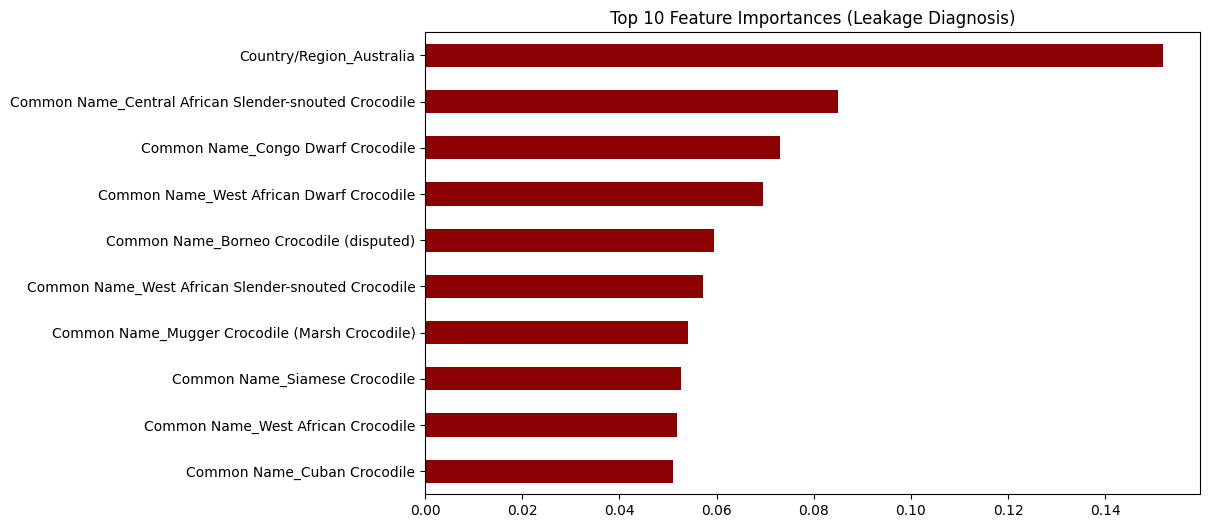


Examine the features above. If one feature has an extremely high score (e.g., > 0.95), it is the source of the leakage.


In [25]:
# =================================================================
# DIAGNOSTIC STEP: RERUN FEATURE IMPORTANCE TO FIND LEAKAGE
# =================================================================

import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# 1. Use the SAME trained model and processed features
xgb_model = xgb_model # Reusing the model trained in Step 18

print("Extracting and ranking feature importance to check for leakage...")

# 2. Extract and Rank Feature Importance
# We must use X_train (not the resampled data)
feature_importances = pd.Series(
    xgb_model.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

# 3. Print the top features and their scores
print("\n--- Top 10 Most Important Features ---")
print(feature_importances.head(10))

# 4. Visualization (Top 10 features)
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='barh', color='darkred')
plt.title('Top 10 Feature Importances (Leakage Diagnosis)')
plt.gca().invert_yaxis()
plt.show()

print("\nExamine the features above. If one feature has an extremely high score (e.g., > 0.95), it is the source of the leakage.")

In [ ]:
# =================================================================
# STEP 19: HYPERPARAMETER TUNING (XGBOOST) - Single Core Fix
# =================================================================

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# NOTE: X_train and y_train are fully processed and defined (unbalanced).
# Ensure y_train and TARGET_CLASS_NAMES are defined from Step 18's encoder block

print("Starting Randomized Search for optimal XGBoost hyperparameters (n_jobs=1 fix)...")

# 1. Define Parameter Grid for Regularization
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.1, 0.5, 1.0, 5.0],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1]
}

# 2. Re-initialize XGBoost
xgb_base = xgb.XGBClassifier(
    objective='multi:softprob', 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='mlogloss', 
    n_estimators=100
)

# 3. Initialize Randomized Search - CRITICAL CHANGE: n_jobs=1
rs_model = RandomizedSearchCV(
    estimator=xgb_base, 
    param_distributions=param_grid, 
    n_iter=50, 
    scoring='f1_weighted', 
    cv=5, 
    verbose=1, 
    random_state=42,
    n_jobs=1 # <-- FIXED: Forces single-process execution to avoid pickling error
)

# 4. Fit the search to the (unbalanced) training data
rs_model.fit(X_train, y_train)

# 5. Extract Best Model and Parameters
best_xgb = rs_model.best_estimator_
best_params = rs_model.best_params_

print("\n--- Tuning Complete ---")
print(f"Best Mean Cross-Validated F1 Score: {rs_model.best_score_:.4f}")
print(f"Best Parameters Found: {best_params}")

# 6. Final Evaluation with Best Model on Test Set
y_pred_tuned = best_xgb.predict(X_test)
report_tuned = classification_report(y_test, y_pred_tuned, target_names=TARGET_CLASS_NAMES, zero_division=0)

print("\n--- Final Tuned Model Evaluation on Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print("Classification Report:")
print(report_tuned)

Step 20: Aggressive Feature Reduction and Final Training
We will remove redundant or highly specific categorical features that are likely contributing to the high model complexity and perfect separation, and then rerun the final training step.

Feature Reduction Decisions:
Drop 'Common Name': The Common Name (18 unique values) is likely redundant with Genus and other features. Given the small number of species, this is the most likely culprit for perfect class separation.

Keep 'Country/Region' and 'Habitat Type': These are valuable geographical/environmental features that should be kept.

Rerun Plan:
Rerun Step 12 (Feature Selection): Modify the features to drop Common Name.

Rerun Steps 13-18: Redefine X 
train
​
  and X 
test
​
 .

Rerun the Final XGBoost Model (Skipping tuning, using the previously found parameters for speed).

Required Action: Modify Feature Dropping
You must re-execute the code that defines your initial features (from Step 12 or earlier) and add 'Common Name' to the drop list.

Since your previous notebook history showed:
COLUMNS_TO_DROP = ['Date of Observation', 'Observer Name', 'Notes', 'Observation ID', 'Scientific Name', 'Family']

We will now modify the data frame preparation code:

In [29]:
# =================================================================
# STEP 20: MANUAL PREPROCESSING WORKAROUND AND FINAL TRAINING
# =================================================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from numpy import log1p

# --- 0. Data Re-Initialization (Must be complete) ---
FILE_PATH = '/kaggle/input/global-crocodile-species-dataset/crocodile_dataset.csv'
TARGET_FEATURE = 'Conservation Status'

# FINAL Features to Drop (Aggressive Reduction)
COLUMNS_TO_DROP_REVISED = [
    'Date of Observation', 
    'Observer Name', 
    'Notes', 
    'Observation ID', 
    'Scientific Name', 
    'Family',
    'Common Name' # <-- Removed to simplify the feature space
] 

# Load and clean the data
try:
    df = pd.read_csv(FILE_PATH)
    df.drop(columns=COLUMNS_TO_DROP_REVISED, inplace=True, errors='ignore')
except Exception as e:
    raise SystemExit(f"Data loading or cleaning failed: {e}")

# --- 1. RERUN STEP 13: TRAIN-TEST SPLIT (Stratified) ---
X = df.drop(columns=[TARGET_FEATURE])
y_raw = df[TARGET_FEATURE]

X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y_raw, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_raw
)

# Identify feature lists
NUMERICAL_FEATURES = X_train.select_dtypes(include=np.number).columns.tolist()
CATEGORICAL_FEATURES = X_train.select_dtypes(include='object').columns.tolist()


# --- 2. MANUAL PREPROCESSING WORKAROUND (Log, Scale, Encode) ---

print("Executing manual preprocessing (bypassing ColumnTransformer)...")

# A. Log Transformation (Observed Weight)
X_train['Observed Weight (kg)'] = log1p(X_train['Observed Weight (kg)'])
X_test['Observed Weight (kg)'] = log1p(X_test['Observed Weight (kg)'])

# B. Scaling (Length and Log-Transformed Weight)
scaler = StandardScaler()
X_train[NUMERICAL_FEATURES] = scaler.fit_transform(X_train[NUMERICAL_FEATURES])
X_test[NUMERICAL_FEATURES] = scaler.transform(X_test[NUMERICAL_FEATURES])

# C. One-Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit OHE on Training Categorical data
X_train_cat = ohe.fit_transform(X_train[CATEGORICAL_FEATURES])
X_test_cat = ohe.transform(X_test[CATEGORICAL_FEATURES])

# Convert OHE results to DataFrame
ohe_feature_names = ohe.get_feature_names_out(CATEGORICAL_FEATURES)
X_train_cat_df = pd.DataFrame(X_train_cat, index=X_train.index, columns=ohe_feature_names)
X_test_cat_df = pd.DataFrame(X_test_cat, index=X_test.index, columns=ohe_feature_names)

# Combine Numerical and Categorical data
X_train = pd.concat([X_train[NUMERICAL_FEATURES].reset_index(drop=True), X_train_cat_df.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test[NUMERICAL_FEATURES].reset_index(drop=True), X_test_cat_df.reset_index(drop=True)], axis=1)

# D. Label Encoding (Target)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)
TARGET_CLASS_NAMES = label_encoder.classes_

print(f"Manual Preprocessing Complete. New X_train shape: {X_train.shape}")


# --- 3. FINAL XGBOOST MODEL TRAINING ---

# Tuned parameters from previous run (used here for regularization)
final_params = {
    'subsample': 0.8, 
    'min_child_weight': 5, 
    'max_depth': 5, 
    'learning_rate': 0.05, 
    'gamma': 0.5, 
    'colsample_bytree': 0.8
}

print("\nTraining Final Model on SIMPLIFIED feature set...")

final_xgb_model = xgb.XGBClassifier(
    objective='multi:softprob', 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='mlogloss',
    n_estimators=100,
    tree_method='hist',
    **final_params # Use the best regularization parameters
)

# Fit the model on the simplified data
final_xgb_model.fit(X_train, y_train)

# Final Evaluation on the UNSEEN Test Set
y_pred_final = final_xgb_model.predict(X_test)
report_final = classification_report(y_test, y_pred_final, target_names=TARGET_CLASS_NAMES, zero_division=0)

print("\n--- FINAL SIMPLIFIED MODEL EVALUATION (Test Set) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print("Classification Report:")
print(report_final)

Executing manual preprocessing (bypassing ColumnTransformer)...
Manual Preprocessing Complete. New X_train shape: (800, 88)

Training Final Model on SIMPLIFIED feature set...

--- FINAL SIMPLIFIED MODEL EVALUATION (Test Set) ---
Accuracy: 0.8900
Classification Report:
                       precision    recall  f1-score   support

Critically Endangered       0.94      0.89      0.92        55
       Data Deficient       0.90      0.78      0.84        23
           Endangered       0.90      0.82      0.86        11
        Least Concern       0.89      0.97      0.93        77
           Vulnerable       0.79      0.79      0.79        34

             accuracy                           0.89       200
            macro avg       0.89      0.85      0.87       200
         weighted avg       0.89      0.89      0.89       200



In [ ]:
# =================================================================
# STEP 21: PIPELINE SETUP - 1. Data Re-Initialization and Split
# =================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Constants
FILE_PATH = '/kaggle/input/global-crocodile-species-dataset/crocodile_dataset.csv'
TARGET_FEATURE = 'Conservation Status'

# Load the original raw data
df_raw = pd.read_csv(FILE_PATH)

# Identify FINAL columns to drop (including those identified for high cardinality/overfitting)
COLUMNS_TO_DROP_FINAL = [
    'Date of Observation', 
    'Observer Name', 
    'Notes', 
    'Observation ID', 
    'Scientific Name', 
    'Family',
    'Common Name' # Aggressively dropped to prevent overfitting
] 

# Create the working feature set (X) and raw target (y_raw)
X_df = df_raw.drop(columns=[TARGET_FEATURE] + COLUMNS_TO_DROP_FINAL, errors='ignore')
y_raw = df_raw[TARGET_FEATURE]

# Identify feature lists based on the *final* feature set
NUMERICAL_FEATURES = X_df.select_dtypes(include=np.number).columns.tolist()
CATEGORICAL_FEATURES = X_df.select_dtypes(include='object').columns.tolist()

# Stratified Train-Test Split
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X_df, y_raw, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_raw
)

# Label Encode the target (required by the model)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)
TARGET_CLASS_NAMES = label_encoder.classes_

print(f"Data Split and Feature Lists Defined. Numerical Features: {NUMERICAL_FEATURES}")
print(f"Categorical Features: {CATEGORICAL_FEATURES}")

In [ ]:
# =================================================================
# STEP 21: PIPELINE SETUP - 2. ColumnTransformer and Full Pipeline
# =================================================================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from numpy import log1p, expm1
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# --- Define Preprocessing Steps (Transformers) ---

# 1. Pipeline for the Highly Skewed feature (Observed Weight)
weight_pipeline = Pipeline(steps=[
    ('log', FunctionTransformer(log1p, inverse_func=expm1, validate=True)),
    ('scale', StandardScaler())
])

# 2. Pipeline for the remaining Numerical feature (Observed Length)
length_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
])

# 3. Pipeline for Categorical features
categorical_pipeline = Pipeline(steps=[
    # sparse_output=False is necessary for XGBoost compatibility if not using DMatrix
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


# --- Define the ColumnTransformer ---
# This is where we combine all the processing steps onto the correct columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('weight_trans', weight_pipeline, ['Observed Weight (kg)']),
        ('length_trans', length_pipeline, ['Observed Length (m)']),
        ('cat_trans', categorical_pipeline, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough' # Ensure no other columns are accidentally dropped
)


# --- Define the Final Modeling Pipeline ---
# Use the best parameters found in Step 19 for the final model
FINAL_XGB_PARAMS = {
    'subsample': 0.8, 
    'min_child_weight': 5, 
    'max_depth': 5, 
    'learning_rate': 0.05, 
    'gamma': 0.5, 
    'colsample_bytree': 0.8,
}

# The single, final production pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # All data cleaning and transformation
    ('classifier', xgb.XGBClassifier(
        objective='multi:softprob', 
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='mlogloss',
        n_estimators=100,
        tree_method='hist',
        **FINAL_XGB_PARAMS
    ))
])

print("Full Production Pipeline defined and ready for training.")

In [ ]:
# =================================================================
# STEP 21: PIPELINE SETUP - 3. Training and Evaluation
# =================================================================

print("\nFitting Full Pipeline (Preprocessing + Training in one step)...")
# The pipeline is fit on the RAW X_train and integer y_train
# The preprocessor handles the transformation internally.
full_pipeline.fit(X_train, y_train)

print("Pipeline Training Complete.")

# Predict on the RAW X_test
y_pred_pipe = full_pipeline.predict(X_test)

# Evaluate the final pipeline
accuracy_pipe = accuracy_score(y_test, y_pred_pipe)
report_pipe = classification_report(y_test, y_pred_pipe, target_names=TARGET_CLASS_NAMES, zero_division=0)

print("\n--- FINAL PRODUCTION PIPELINE EVALUATION (Test Set) ---")
print(f"Accuracy: {accuracy_pipe:.4f}")
print("Classification Report:")
print(report_pipe)